# Lueschers Formula test in 3, 2, 1 dimensions

## Initialization

In [1]:
# Python modules
import itertools
import time

# Data management
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pylab as plt
import seaborn as sns

# Fitting
import scipy.optimize as opt
import gvar as gv
import lsqfit

# Project modules
import luescher_nd.utilities as ut

In [2]:
%load_ext blackcellmagic

### Parameters

Quantities will be expressed in units of [fm]. Energies are converted to inverse fermi using $\hbar c = 197.326$ MeV/fm.

In [3]:
HBARC = 197.326 # MeV / fm
E_DEUTERON = - 2.225 / HBARC
M_NUCLEON = (938.27 + 939.57) / 2 / HBARC

NDIM_MAX = 3
N1D_MAX = 20
LATTICE_SPACING = 1.97

## Kinetic Hamiltonian

Here, a few cross checks for the kinetic Hamiltonian are implemented.

In [16]:
n1d = 4
ndim = 2
shifts = {-1: 1., 0: -2., 1: 1.}

H0 = get_kinetic_hamiltonian(
    n1d_max=n1d, ndim_max=ndim, derivative_shifts=shifts, lattice_spacing=LATTICE_SPACING
).toarray()

#### Test if operator is hermitean

In [17]:
np.testing.assert_equal(H0, H0.T.conj())

#### Test eigenvalues of the operator

The eigenvlues of the discrete kinetic Hamiltonian are given by
$$
    E(\vec p) = - \frac{1}{M_N \epsilon^2}\left[
        \sum_{n_d = 1}^{n_{dim}}
        \sum_{n_s = - n_{step}}^{n_{step}}
        c_{n_s} \cos( p_{n_d}  n_{step} \epsilon )
    \right] \, ,
$$

where $p_L$ are the lattice momenta defined by
$$
    p_{n_d}(\vec n, \vec \phi)
    =
    \frac{2 \pi n_{n_d}}{L} + \frac{\phi_{n_d} }{L}
    \, .
$$

The vector $\vec n$ runs over all allowed lattice grid points.

In [19]:
L = n1d * LATTICE_SPACING

energies = []

for n in itertools.product(*[range(n1d)] * ndim):
    En = 0
    for ni in n:
        pi = 2 * np.pi * ni / L

        for nstep, coeff in shifts.items():
            En -= coeff * np.cos(pi * nstep * LATTICE_SPACING)

    energies.append(En)

energies = np.array(energies) / M_NUCLEON / LATTICE_SPACING ** 2

eigs, vecs = np.linalg.eigh(H0)

# Sort to enable comparism
energies.sort()
eigs.sort()

np.testing.assert_array_almost_equal(energies, eigs)

## Computation

### 1-D computations

Even if the contact interaction used to pin down the phase shift does not depent on a ultra-violett cuttoff, it depends on the lattice spacing. Thus one must extrapolate results to the continuum before using Lüschers formula.

Luckily, there is a one-to-one correspondence of finite volume contact interaction to continuum results:

$$
c_a(a, E_B) = c_0 \sqrt{1 + \frac{\gamma^2 a^2}{4}}
\, , \qquad
\gamma = \sqrt{- 2 \mu E_B}\, .
$$

Thus one must fix $c_a$, compute $E_B$, relate $c_a$ to $c_0$ using $E_B$ and then use Lüschers formula.

In [4]:
L = 20.
c0 = -1.0
mu = M_NUCLEON / 2
gamma0 = -c0 * mu
E0 = - gamma0**2 / 2 / mu

lattice_spacings = np.linspace(1.e-1, 4.0, 101)[::-1]

cas = c0 * np.sqrt(1 + gamma0 ** 2 * lattice_spacings ** 2 / 4)

energies = []

for aL, ca in zip(lattice_spacings, cas):

    n1d_max = int(L / aL)

    solver = ut.Solver(
        n1d_max=n1d_max,
        ndim_max=1,
        lattice_spacing=aL,
    )
    psi0 = ut.get_approx_psi0(
        particle_energy=E0, 
        n1d_max=n1d_max, 
        ndim_max=1, 
        lattice_spacing=aL
    )

    E0 = solver.get_ground_state(ca, v0=psi0)

    energies.append(E0)

energies = np.array(energies)

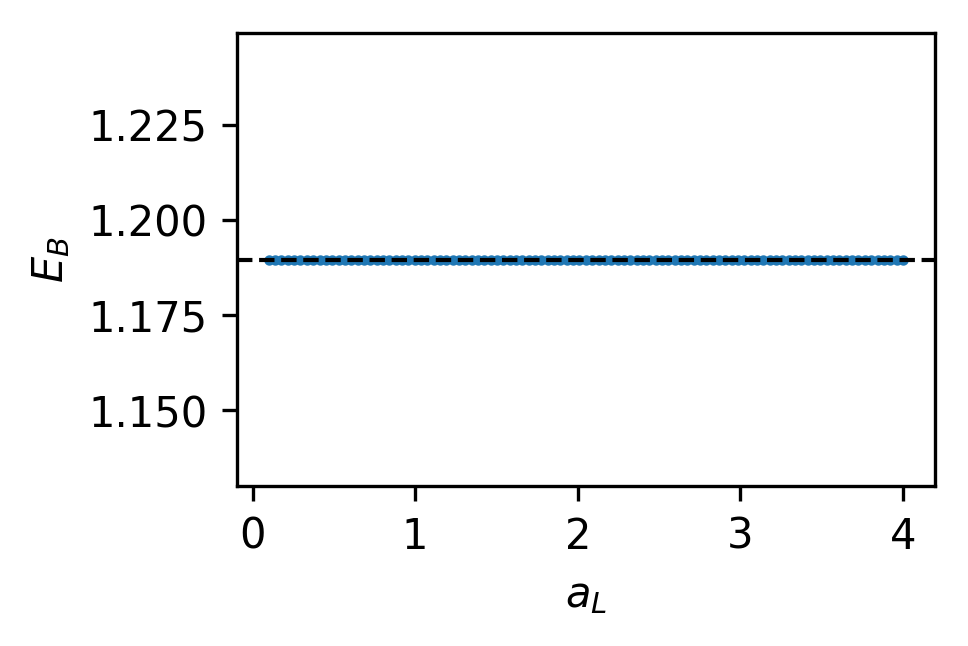

In [7]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)

gamma = np.sqrt(-2 * mu * np.array(energies))

c0s = cas / np.sqrt(1 * gamma ** 2 * lattice_spacings ** 2 / 4)

ax.plot(lattice_spacings, -energies, ".", ms=3, zorder=2)
ax.axhline(+gamma0 ** 2 / mu / 2, lw=1, ls="--", c="black")

ax.set_ylim(gamma0 ** 2 / mu / 2 * 0.95, gamma0 ** 2 / mu / 2 * 1.05)
ax.set_ylabel("$E_B$")
ax.set_xlabel("$a_L$")

plt.show(fig)


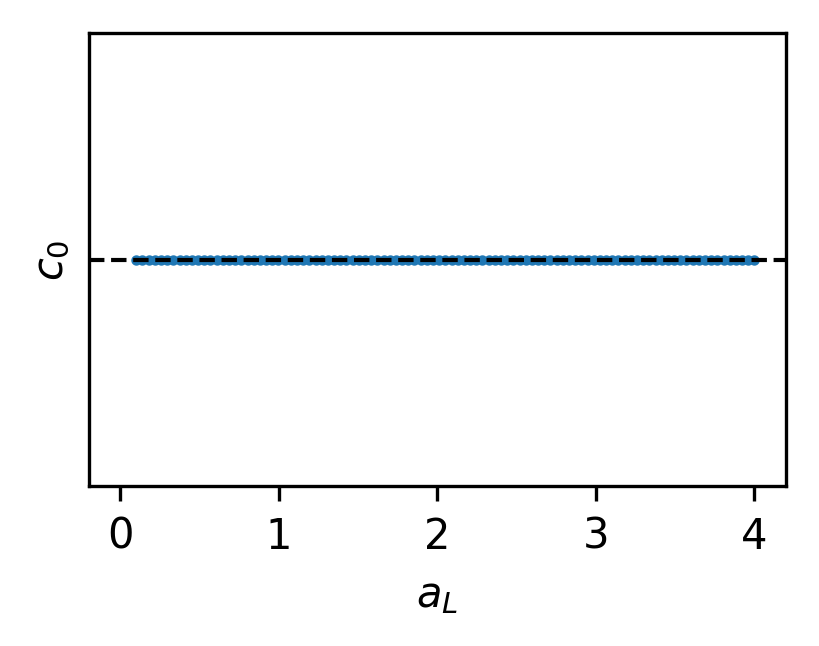

In [8]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)

gamma = np.sqrt(-2 * mu * np.array(energies))

c0s = cas / np.sqrt(1 + gamma ** 2 * lattice_spacings ** 2 / 4)

ax.plot(lattice_spacings, c0s, ".", ".", ms=3, zorder=2)
ax.axhline(c0, lw=1, ls="--", c="black")

ax.set_ylim(c0 * 0.8, c0 * 1.2)
ax.set_ylabel("$c_0$")
ax.set_xlabel("$a_L$")

plt.show(fig)

In [9]:
def s1(x):
    if x > 0:
        return - np.pi / np.tan(np.pi * np.sqrt(x)) / np.sqrt(x)
    else:
        return np.pi / np.tanh(np.pi * np.sqrt(-x)) / np.sqrt(-x)

In [16]:
L = 20.
c0 = -1.0
mu = M_NUCLEON / 2
gamma0 = -c0 * mu
E0 = - gamma0**2 / 2 / mu

lattice_spacings = np.linspace(1.e-1, 4.0, 101)[::-1]

cas = c0 * np.sqrt(1 + gamma0 ** 2 * lattice_spacings ** 2 / 4)

a0_lattice = []
a0 = []
a0ca = []

for aL, ca in zip(lattice_spacings, cas):

    n1d_max = int(L / aL)

    solver = ut.Solver(
        n1d_max=n1d_max,
        ndim_max=1,
        lattice_spacing=aL,
        derivative_shifts={-1: 1., 0: -2, 1: 1.},
    )
    psi0 = ut.get_approx_psi0(E0, n1d_max=n1d_max, ndim_max=1, lattice_spacing=aL)

    E0 = solver.get_ground_state(ca, v0=psi0)

    L = n1d_max * aL

    p = np.sqrt(- E0 * mu *2)
    x = (p * L / 2 / np.pi)**2
    
    a0_lattice.append(s1( -x ) * L / 2 / np.pi**2)
    
    c0 = ca / np.sqrt(1 + p**2 * aL**2 / 4)
    
    a0.append(-2 / (mu*2) / c0)
    a0ca.append(-2 / (mu*2) / ca) 

    

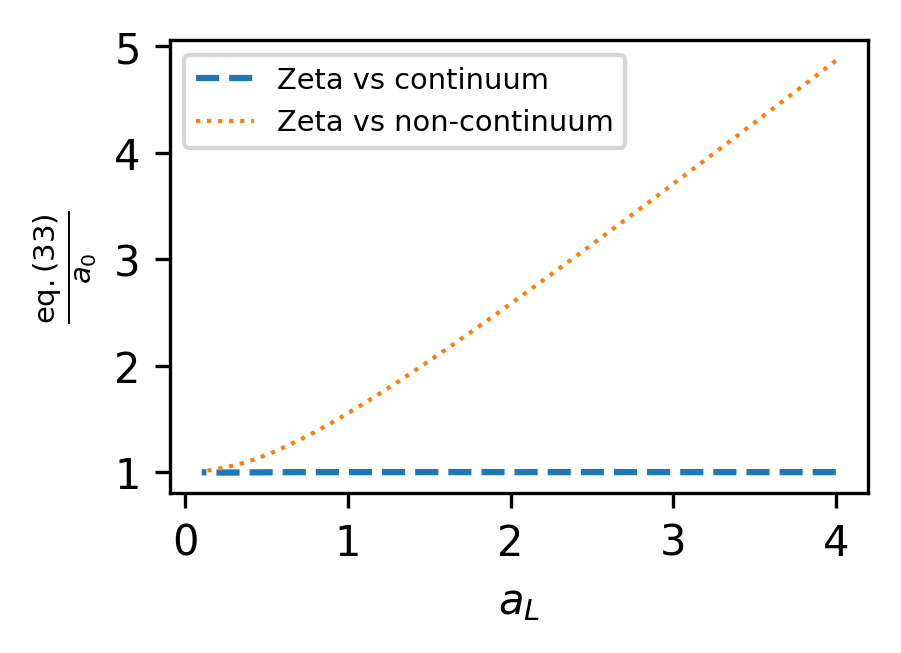

In [17]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)

ax.plot(lattice_spacings, np.array(a0_lattice)/np.array(a0), "--", ms=3, zorder=2, label="Zeta vs continuum")
#ax.plot(lattice_spacings, a0, "--", lw=1, zorder=2, label="Continuum $a_0$")
ax.plot(lattice_spacings, np.array(a0_lattice)/np.array(a0ca), ":", lw=1, zorder=2, label="Zeta vs non-continuum")
#ax.axhline(c0, lw=1, ls="--", c="black")

#ax.set_ylim(a0[0] * 0.8, a0[0] * 1.2)
ax.set_ylabel(r"$\frac{\mathrm{eq.}(33)}{a_0}$")
ax.set_xlabel("$a_L$")

ax.legend(fontsize="x-small")

plt.show(fig)

In [14]:
(res/a0)

NameError: name 'res' is not defined

Questions:
* What is `m` -> Nucleon not relative?
* What happens if E is negative?
